# RNN与ODE

本文主要参考以下内容看看RNN拟合微分算子的能力，并尝试了解下RNN和ODE的关系。

- [貌离神合的RNN与ODE：花式RNN简介](https://kexue.fm/archives/5643)
- [GlassyWing/ode_rnn](https://github.com/GlassyWing/ode_rnn)
- [Recurrent Neural Network Models for Predicting ODE Dynamics](https://www.math.unl.edu/~ncuwm/23rdAnnual/presentation-library/presentations/talk/Renaud_Camille_NCUWM2021Talk.pdf)

注：本文并非热点“神经ODE”的介绍（但有一定的联系）。

## 什么是RNN？

众所周知，RNN是“循环神经网络（Recurrent Neural Network）”，跟CNN不同，RNN可以说是一类模型的总称，而并非单个模型。简单来讲，只要是输入向量序列$(x_1,x_2,\cdots,x_T)$，输出另外一个向量序列$(y_1,y_2,\cdots,y_T)$，并且满足如下递归关系

$y_t=f(y_{t-1},x_t,t) \tag 1$

的模型，都可以称为RNN。也正因为如此，原始的朴素RNN，还有改进的如GRU、LSTM、SRU等模型，我们都称为RNN，因为它们都可以作为上式的一个特例。

说白了，RNN其实就是递归计算。

自定义自己的RNN不复杂。在Tensorflow、PyTorch、Jax等库中，只要写出每一步的递归函数就行；

最基本的RNN递归函数如下所示：

$$ y_t=tanh(W_1y_{t-1}+W_2x_t+b) \tag 2$$

## ODE基本

### 什么是ODE?

ODE就是“常微分方程（Ordinary Differential Equation）”，这里指的是一般的常微分方程组：

$$\dot x(t)=f(x(t),t)\tag 3$$

研究ODE的领域通常也直接称为“动力学”、“动力系统”，这是因为牛顿力学通常就是一组ODE。

ODE可以产生非常丰富的函数。比如$e^t$其实就是$\dot x=x$的解，sin t和cos t都是$\ddot x+x=0$的解（初始条件不同）。有一些教程就是直接通过微分方程$\dot x=x$来定义$e^t$函数的。除了这些初等函数，很多我们能叫得上名字但不知道是什么鬼的特殊函数，都是通过ODE导出来的，比如超几何函数、勒让德函数、贝塞尔函数...

总之，ODE能产生并且已经产生了各种各样千奇百怪的函数～

### 数值解ODE 

能精确求出解析解的ODE其实是非常少的，所以很多时候我们都需要数值解法。

ODE的数值解已经是一门非常成熟的学科了，这里仅引入最基本的由数学家欧拉提出来的迭代公式：

$$ x(t+h)=x(t)+hf(x(t),t)\tag 4$$

这里的h是步长。欧拉的解法来源很简单，就是用

$$\frac{x(t+h)−x(t)}{h}\tag 5$$

来近似导数项$\dot x(t)$。只要给定初始条件x(0)，我们就可以根据(4)一步步迭代算出每个时间点的结果。

## ODE与RNN

### ODE也是RNN

仔细对比(4)和(1)，发现有什么联系了吗？

在(1)中，t是一个整数变量，在(4)中，t是一个浮点变量，除此之外，(4)跟(1)貌似就没有什么明显的区别了。事实上，在(4)中我们可以以h为时间单位，记t=nh，那么(4)变成了

$$x((n+1)h)=x(nh)+hf(x(nh),nh)\tag 6$$

可以看到现在(6)中的时间变量n也是整数了。

这样一来，我们就知道：ODE的欧拉解法(4)实际上就是RNN的一个特例了。这里我们也许可以间接明白为什么RNN的拟合能力如此之强了（尤其是对于时间序列数据），我们看到ODE可以产生很多复杂的函数，而ODE只不过是RNN的一个特例罢了，所以RNN应该可以产生更为复杂的函数。

### 用RNN解ODE #

于是，我们就可以写一个RNN来解ODE了，比如《两生物种群竞争模型》中的例子：

即解下面的微分方程：

$$ \begin{cases} 
\frac{d{x_1}}{dt} = r_1x_1(1-\frac{x_1}{N_1}) - a_1x_1x_2 \\
\frac{d{x_2}}{dt} = r_2x_2(1 - \frac{x_2}{N_2}) - a_2x_1x_2
\end{cases} \tag 7$$

In [1]:
import torch.nn as nn
import torch
from torch.optim import Adam, SGD
import numpy as np
import matplotlib.pyplot as plot

In [17]:
class ODE_RNN(nn.Module):

    def __init__(self, steps, h):
        super().__init__()
        self.steps = steps
        self.h = h

        self.weights = nn.Parameter(
            torch.tensor([0.1,0.3,0.0001,0.0002,0.002,0.003], dtype=torch.float32)
            , requires_grad=True)

    def step_do(self, state):
        x = state
        r1, r2, a1, a2, iN1, iN2 = (self.weights[0], self.weights[1],
                                    self.weights[2], self.weights[3],
                                    self.weights[4], self.weights[5])
        _1 = r1 * x[:, 0] * (1 - iN1 * x[:, 0]) - a1 * x[:, 0] * x[:, 1]
        _2 = r2 * x[:, 1] * (1 - iN2 * x[:, 1]) - a2 * x[:, 0] * x[:, 1]
        # 防止梯度爆炸
        _ = torch.stack((_1, _2), dim=-1)
        # 欧拉法求下一步
        step_out = x + self.h * torch.clamp(_, -1e5, 1e5)
        return step_out, step_out

    def forward(self, init):
        state = init
        outputs = []
        for step in range(self.steps):
            step_out, state = self.step_do(state)
            outputs.append(step_out)

        outputs = torch.stack(outputs, dim=1)

        return outputs


mse_loss = torch.nn.MSELoss(reduction='none')


def ode_loss(y_true, y_pred):
    mask = torch.sum(y_true, dim=-1, keepdim=True) > 0
    mask = mask.float()

    return torch.sum(mask * mse_loss(y_true, y_pred)) / mask.sum()

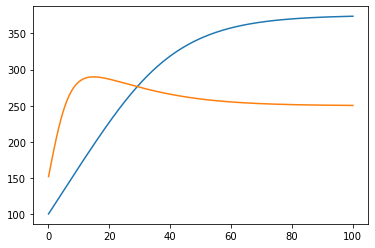

In [18]:
# 直接前向传播就输出解了
steps,h = 1000,0.1
ode_rnn = ODE_RNN(steps, h)
result = ode_rnn(torch.Tensor(np.array([[100, 150]])))[0] # 以[100, 150]为初始条件进行演算
times = np.arange(1, steps+1) * h

# 绘图
plot.plot(times, result[:,0].detach().numpy() )
plot.plot(times, result[:,1].detach().numpy() )

整个过程很容易理解，只不过有两点需要指出一下。首先，由于方程组(7)只有两维，而且不容易写成矩阵运算，因此在step_do函数中是直接逐位操作的（代码中的x[:,0],x[:,1]），如果方程本身维度较高，而且能写成矩阵运算，那么直接利用矩阵运算写会更加高效；可以看到出，写完整个模型之后，直接predict就能输出结果了，前向计算就对应了欧拉求解。

### 反推ODE参数

RNN的前向传播跟ODE的欧拉解法是对应的，那么反向传播又对应什么呢？

在实际问题中，有一类问题称为“模型推断”，它是在已知实验数据的基础上，猜测这批数据符合的模型（机理推断）。这类问题的做法大概分两步，第一步是猜测模型的形式，第二步是确定模型的参数。假定这批数据可以由一个ODE描述，并且这个ODE的形式已经知道了，那么就需要估计里边的参数。

如果能够用公式完全解出这个ODE，那么这就只是一个非常简单的回归问题罢了。但前面已经说过，多数ODE都没有公式解，所以数值方法就必须了。这其实就是ODE对应的RNN的反向传播所要做的事情：前向传播就是解ODE（RNN的预测过程），反向传播自然就是推断ODE的参数了（RNN的训练过程）。这是一个非常有趣的事实：ODE的参数推断是一个被研究得很充分的课题；而在深度学习这里，是RNN的一个基本应用。

把刚才的例子的微分方程的解数据保存下来，然后只取几个点，看看能不能反推原来的微分方程出来，解数据为：

$\begin{array}{c|ccccccc} 
\hline 
\text{时间} & 0 & 10 & 15 & 30 & 36 & 40 & 42\\ 
\hline 
x_1 & 100 & 165 & 197 & 280 & 305 & 318 & 324\\ 
\hline 
x_2 & 150 & 283 & 290 & 276 & 269 & 266 & 264\\ 
\hline 
\end{array}$

假设就已知这有限的点数据，然后假定方程(7)的形式，求方程的各个参数。下面是训练过程的函数。

因为上面相当于是我们最终训练好的参数。所以这里重新初始化下参数后再训练

In [20]:
class ODE_RNN(nn.Module):

    def __init__(self, steps, h):
        super().__init__()
        self.steps = steps
        self.h = h

        # 初始化6个参数
        self.weights = nn.Parameter(
            torch.tensor([0.1, 0.1, 0.001, 0.001, 0.001, 0.001], dtype=torch.float32)
            , requires_grad=True)

    def step_do(self, state):
        x = state
        r1, r2, a1, a2, iN1, iN2 = (self.weights[0], self.weights[1],
                                    self.weights[2], self.weights[3],
                                    self.weights[4], self.weights[5])
        _1 = r1 * x[:, 0] * (1 - iN1 * x[:, 0]) - a1 * x[:, 0] * x[:, 1]
        _2 = r2 * x[:, 1] * (1 - iN2 * x[:, 1]) - a2 * x[:, 0] * x[:, 1]

        _ = torch.stack((_1, _2), dim=-1)

        # 梯度截断，防止梯度爆炸
        step_out = x + self.h * torch.clamp(_, -1e5, 1e5)
        return step_out, step_out

    def forward(self, init):
        state = init
        outputs = []
        for step in range(self.steps):
            step_out, state = self.step_do(state)
            outputs.append(step_out)

        outputs = torch.stack(outputs, dim=1)

        return outputs


In [21]:
steps, h = 50, 1

series = {0: [100, 150],
              10: [165, 283],
              15: [197, 290],
              30: [280, 276],
              36: [305, 269],
              40: [318, 266],
              42: [324, 264]}
X = np.array([series[0]])
Y = np.zeros((1, steps, 2))

for i, j in series.items():
    if i != 0:
        Y[0, int(i / h) - 1] += series[i]

X = torch.tensor(X).float()
Y = torch.tensor(Y).float()

model = ODE_RNN(steps, h)
optimizer = Adam(model.parameters(), lr=1e-4)

for epoch in range(1, 10001):
    outputs = model(X)
    loss = ode_loss(Y, outputs)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    if epoch ==1 or epoch % 1000 == 0:
        print(epoch, loss.item())

with torch.no_grad():
    result = model(torch.tensor([[100, 150]], dtype=torch.float32))[0]
    times = np.arange(1, steps + 1) * h

1 152561.625
1000 441.8132019042969
2000 362.2705383300781
3000 320.1658935546875
4000 218.49159240722656
5000 148.6073760986328
6000 97.77352905273438
7000 61.720062255859375
8000 40.653297424316406
9000 22.77106475830078
10000 22.619422912597656


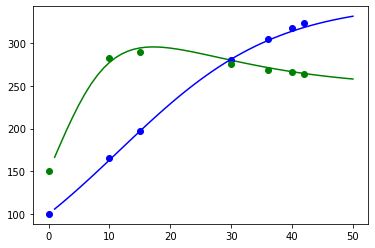

In [22]:
plot.plot(times, result[:, 0], color='blue')
plot.plot(times, result[:, 1], color='green')

plot.plot(list(series.keys()), [i[0] for i in series.values()], 'o', color='blue')
plot.plot(list(series.keys()), [i[1] for i in series.values()], 'o', color='green')
plot.savefig('ode_a.png')

可以发现效果不错，虽然训练迭代次数很长。

需要注意的是，在RNN模型的反向传播中，要**谨慎地做好初始化和截断处理处理，并且选择好学习率**等，以防止梯度爆炸的出现（梯度消失只是优化得不够好，梯度爆炸则是直接崩溃了，解决梯度爆炸问题尤为重要）。

总之，梯度消失和梯度爆炸在RNN中是一个很经典的困难，事实上，LSTM、GRU等模型的引入，根本原因就是为了解决RNN的梯度消失问题，而梯度爆炸则是通过使用tanh或sigmoid激活函数来解决的。但是如果用RNN解决ODE的话，我们就没有选择激活函数的权利了（激活函数就是ODE的一部分），所以只能谨慎地做好初始化及其他处理。据说，只要谨慎做好初始化，普通RNN中用relu作为激活函数都是无妨的～

## 微分方程形式未知

对于很多实际问题，通常无法准确获知微分方程的具体形式，不过根据欧拉解法：

$$ x(t+h) = x(t) + hf(x(t), t) $$

虽然$f$未知，但是深度学习有个万能近似定理，我们直接用一个多层全连接网络近似这个$f$即可。（这应该就是残差网络了吧。）

In [5]:
class ODE_RNN(nn.Module):

    def __init__(self, steps, input_size, hidden_size):
        super().__init__()
        self.steps = steps

        self.d_f = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.SELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.SELU(),
            nn.Linear(hidden_size, input_size)
        )

    def step_do(self, state):
        x = state

        _ = self.d_f(x)

        step_out = x + torch.clamp(_, -1e5, 1e5)
        return step_out, step_out

    def forward(self, init, steps=None):
        state = init
        outputs = []

        steps = self.steps if steps is None else steps

        for step in range(steps):
            step_out, state = self.step_do(state)
            outputs.append(step_out)

        outputs = torch.stack(outputs, dim=1)

        return outputs


mse_loss = torch.nn.MSELoss(reduction='none')


def ode_loss(y_true, y_pred):
    mask = torch.sum(y_true, dim=-1, keepdim=True) > 0
    mask = mask.float()

    return torch.sum(mask * mse_loss(y_true, y_pred)) / mask.sum()

ok，现在完全不知道这个微分方程的形式，训练10000次，效果如下

In [8]:
steps, h = 50, 1

series = {0: [100, 150],
              10: [165, 283],
              15: [197, 290],
              30: [280, 276],
              36: [305, 269],
              40: [318, 266],
              42: [324, 264]}

X = np.array([series[0]])
Y = np.zeros((1, steps, 2))

for i, j in series.items():
    if i != 0:
        Y[0, int(i / h) - 1] += series[i]

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

model = ODE_RNN(steps, input_size=2, hidden_size=64)
optimizer = Adam(model.parameters(), lr=1e-3)

for epoch in range(1, 10001):
    outputs = model(X)
    loss = ode_loss(Y, outputs)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    if epoch ==1 or epoch % 1000 == 0:
        print(epoch, loss.item())

with torch.no_grad():
    result = model(torch.tensor([[100, 150]], dtype=torch.float32))[0]
    times = np.arange(1, steps + 1) * h

1 2670503.75
1000 1969.3519287109375
2000 679.6394653320312
3000 298.6558532714844
4000 236.5548095703125
5000 182.4418182373047
6000 154.80984497070312
7000 114.89645385742188
8000 71.47338104248047
9000 81.54005432128906
10000 3.019988775253296


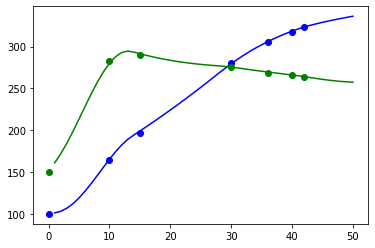

In [9]:
plot.clf()
plot.plot(times, result[:, 0], color='blue')
plot.plot(times, result[:, 1], color='green')

plot.plot(list(series.keys()), [i[0] for i in series.values()], 'o', color='blue')
plot.plot(list(series.keys()), [i[1] for i in series.values()], 'o', color='green')
plot.savefig('ode_b.png')

基于以上的拟合结果可知，即使微分方程的形式未知，RNN网络同样能够找到一个足够近似$f$的函数。（代码中之所以使用SELU激活，主要是考虑到tanh的激活区间太窄，在数据数值很大，或没有做归一化操作时，tanh的梯度几乎为0，而RELU由于激活抑制，最终得到的曲线不是光滑曲线，使用SELU这类函数会有更好结果）。

## 更多

求解微分方程仅仅只是RNN中的一个特例，理论上更复杂的结构，如LSTM，会得到更好的结果，下面使用LSTM进行替换（这应该相当于去学习微分方程了吧）：

In [10]:
class ODE_LSTM(nn.Module):

    def __init__(self, steps, input_size, hidden_size, num_layers):
        super().__init__()
        self.steps = steps

        self.en = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.de = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True,)

        self.o_net = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.SELU(),
            nn.Linear(hidden_size, input_size)
        )

    def forward(self, init, steps=None):
        steps = self.steps if steps is None else steps

        # 实际上不需要进行输入，只是官方实现需要输入
        zeros = torch.zeros(init.shape[0],
                            steps,
                            init.shape[1],
                            dtype=init.dtype)

        _, init_state = self.en(init.unsqueeze(1))

        outputs, _ = self.de(zeros, init_state)

        # steps
        outputs = self.o_net(outputs)

        return outputs


mse_loss = torch.nn.MSELoss(reduction='none')


def ode_loss(y_true, y_pred):
    mask = torch.sum(y_true, dim=-1, keepdim=True) > 0
    mask = mask.float()

    return torch.sum(mask * mse_loss(y_true, y_pred)) / mask.sum()

上面代码用一个LSTM获取第一步的初始值，然后另一个LSTM进行微分方程的拟合（虽然此时已经不能用单纯的微分拟合来解释网络的行为了），因此与其说用LSTM，不如说使用的seq2seq。由于LSTM的官方实现没有进行梯度截断，激活函数也是使用的tanh，因此在训练前对数据进行了归一化处理。以下是迭代1500次后的拟合结果：

In [11]:
steps, h = 50, 1

ori_series = {0: [100, 150],
                  10: [165, 283],
                  15: [197, 290],
                  30: [280, 276],
                  36: [305, 269],
                  40: [318, 266],
                  42: [324, 264]}

# 归一化，这一步很重要，否则很难train下去
series = {}
for k, v in ori_series.items():
    series[k] = [(v[0] - 100) / (324 - 100), (v[1] - 150) / (264 - 150)]

X = np.array([series[0]])
Y = np.zeros((1, steps, 2))

for i, j in series.items():
    if i != 0:
        Y[0, int(i / h) - 1] += series[i]

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

model = ODE_LSTM(steps, input_size=2, hidden_size=64, num_layers=2)
optimizer = Adam(model.parameters(), lr=1e-4)

for epoch in range(1, 1501):
    outputs = model(X)
    loss = ode_loss(Y, outputs)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    if epoch == 1 or epoch % 150 == 0:
        print(epoch, loss.item())

with torch.no_grad():
    result = model(torch.tensor([[0, 0]], dtype=torch.float32))[0]
    result = result * torch.tensor([324 - 100, 264 - 150], dtype=torch.float32) + \
                 torch.tensor([100, 150], dtype=torch.float32)
    times = np.arange(1, steps + 1) * h

1 1.9826397895812988
150 0.06473252177238464
300 0.017810644581913948
450 0.000756212801206857
600 0.0003997526364400983
750 0.00018359992827754468
900 6.369779293891042e-05
1050 1.905719364003744e-05
1200 8.19298566057114e-06
1350 5.983472419757163e-06
1500 5.36413790541701e-06


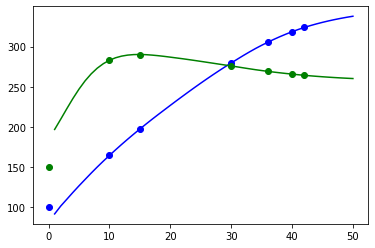

In [12]:
plot.clf()
plot.plot(times, result[:, 0], color='blue')
plot.plot(times, result[:, 1], color='green')

plot.plot(list(ori_series.keys()), [i[0] for i in ori_series.values()], 'o', color='blue')
plot.plot(list(ori_series.keys()), [i[1] for i in ori_series.values()], 'o', color='green')
plot.savefig('ode_c.png')

从结果上看，seq2seq仅仅使用1500次迭代，就得到了超过前述方法的效果，证明seq2seq的结构优越性。

## 结论

通过整个的介绍看，证明RNN具备相当强大的微分方程拟合能力的同时，还有下面结论：

- 已知微分方程，RNN（仅本文中的特定RNN）的前向传播过程等效于积分
- 已知一个函数上的多个点，它的微分方程未知，这时RNN（仅本文中的特定RNN）的反向传播等效于求解微分方程

## 应用

几乎可以应用在所有需要求解微分方程的问题中，并且RNN天然就是处理时序数据的工具。以气温预测为例，只要知道了气温变化的微分方程，就可以在一定程度上对气温进行预测。当然实际情况中，温度变化不止是一个点的变化，而是整个空间中的温度变化，可以结合重整化、粗粒化等技巧，实现真正的气象预测。